In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download and load dataset
import requests
import zipfile
import os

# Define dataset URL and paths
url = "https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip"
zip_path = "turbofan_data.zip"
extract_path = "./data"

# Download the dataset
response = requests.get(url)
with open(zip_path, "wb") as f:
    f.write(response.content)

# Extract the dataset
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Load training data
df = pd.read_csv(os.path.join(extract_path, 'train_FD001.txt'), sep=' ', header=None)
df = df.iloc[:, :26]  # Filter relevant columns

columns = ['engine_no', 'cycle', 'operational_setting_1', 'operational_setting_2',
           'operational_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
df.columns = columns

df.head()


,engine_no,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
# Add RUL column
# Calculate Remaining Useful Life (RUL) for each engine
df['RUL'] = df.groupby('engine_no')['cycle'].transform('max') - df['cycle']

# Drop unnecessary columns (only operational_setting_1, operational_setting_2, operational_setting_3)
df = df.drop(columns=['operational_setting_1', 'operational_setting_2', 'operational_setting_3'])

# Normalize sensor data
scaler = MinMaxScaler()
sensor_columns = [col for col in df.columns if 'sensor_' in col]
df[sensor_columns] = scaler.fit_transform(df[sensor_columns])

df.head()

,engine_no,cycle,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


In [4]:
# Split data into training and testing
X = df[sensor_columns]
y = df['RUL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (16504, 21)
Testing data shape: (4127, 21)


In [5]:
# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

In [17]:
# Evaluate model performance
msa = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random forest MAE: {msa}")
print(f"Random forest R^2 Score: {r2}")

Random forest MAE: 29.572015992246186
Random forest R^2 Score: 0.6246941408226915


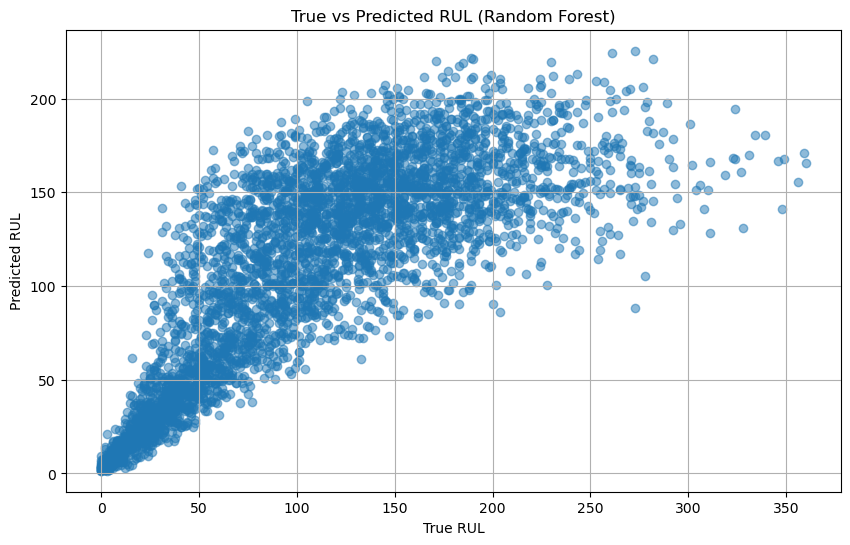

In [14]:
# Plot true vs predicted RUL
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL (Random Forest)")
plt.grid()
plt.show()


In [9]:
# Long Short-Term Memory (LSTM)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Prepare data for LSTM
sequence_length = 50  # Define the number of cycles to use as sequence input
feature_columns = [col for col in df.columns if col not in ['RUL', 'engine_no']]

# Scale the data
scaler = MinMaxScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])

# Create sequences for LSTM
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(target.iloc[i+seq_length])
    return np.array(X), np.array(y)

# Filter data by engine and combine sequences
X_lstm, y_lstm = [], []
for engine in df['engine_no'].unique():
    engine_data = df[df['engine_no'] == engine]
    X_seq, y_seq = create_sequences(engine_data[feature_columns], engine_data['RUL'], sequence_length)
    X_lstm.append(X_seq)
    y_lstm.append(y_seq)

X_lstm = np.concatenate(X_lstm)
y_lstm = np.concatenate(y_lstm)

# Split into train and test sets
split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

In [11]:
# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, len(feature_columns))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile and train
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

Epoch 1/20
196/196 [==============================] - 21s 82ms/step - loss: 8108.8262 - val_loss: 11481.6084
Epoch 2/20
196/196 [==============================] - 15s 76ms/step - loss: 7126.0591 - val_loss: 10483.2109
Epoch 3/20
196/196 [==============================] - 15s 76ms/step - loss: 6396.4844 - val_loss: 9626.5000
Epoch 4/20
196/196 [==============================] - 15s 75ms/step - loss: 5764.4702 - val_loss: 8874.2070
Epoch 5/20
196/196 [==============================] - 15s 78ms/step - loss: 5230.4077 - val_loss: 8218.1533
Epoch 6/20
196/196 [==============================] - 15s 76ms/step - loss: 4788.4619 - val_loss: 7647.9766
Epoch 7/20
196/196 [==============================] - 16s 83ms/step - loss: 4395.8789 - val_loss: 7151.7812
Epoch 8/20
196/196 [==============================] - 17s 84ms/step - loss: 4081.9919 - val_loss: 6724.0488
Epoch 9/20
196/196 [==============================] - 15s 78ms/step - loss: 3826.1218 - val_loss: 6355.1079
Epoch 10/20
196/196 [=====

In [15]:
# Predict and evaluate
y_pred_lstm = model.predict(X_test_lstm).flatten()  # Flatten predictions to match y_test_lstm
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

print(f"LSTM MAE: {mae_lstm:.4f}")
print(f"LSTM R^2 Score: {r2_lstm:.4f}")


98/98 [==============================] - 3s 22ms/step
LSTM MAE: 54.4936
LSTM R^2 Score: -0.0735
